In [5]:
import numpy as np
import pandas as pd
import mne
import glob
import os

from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft

### Upload data

In [6]:
edf_file_path = glob.glob(os.path.join("data", '*.edf'))[0]
csv_file_path = glob.glob(os.path.join("data", '*.csv'))[0]

prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)

# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)

Extracting EDF parameters from /Users/waddaben/Desktop/code/idn-sync-data/data/16804 - Night 2 - 555717 - output-scoring.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2591999  =      0.000 ... 21599.992 secs...


### Unpack prodigy

['AUDIO', 'CHIN', 'LEFT_EEG', 'LEFT_EYE', 'MASTOID', 'POSITION', 'RIGHT_EEG', 'RIGHT_EYE']


(0.0, 5.0)

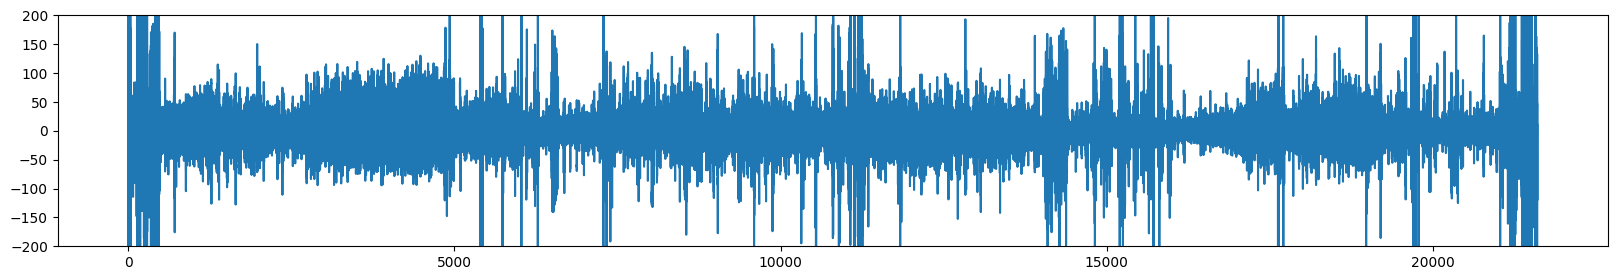

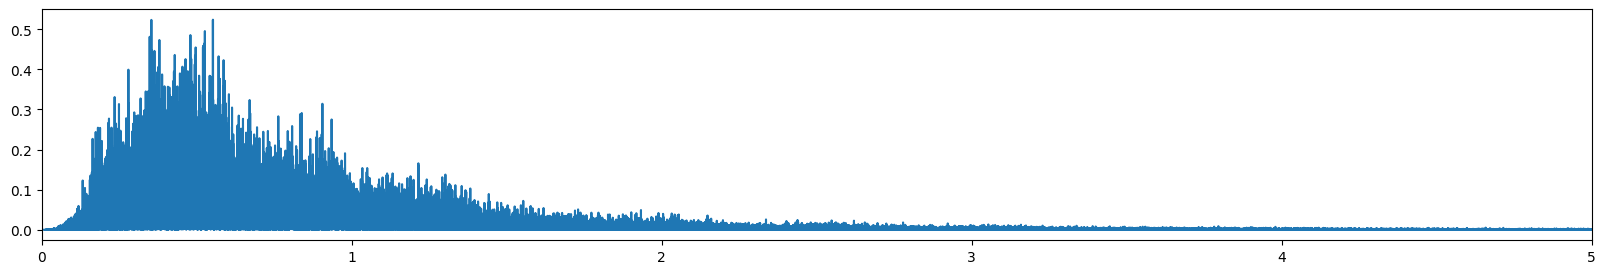

In [27]:
CHANNEL_1 = "LEFT_EYE"
CHANNEL_2 = "RIGHT_EYE"
PRODIGY_SAMPLE_RATE = 120
prodigy_data, prodigy_times = prodigy_raw_data[:, :]
prodigy_channel_names = prodigy_raw_data.ch_names
print(prodigy_channel_names)
# find the position of the channels in channel_names
channel_1_index = prodigy_channel_names.index(CHANNEL_1)
channel_2_index = prodigy_channel_names.index(CHANNEL_2)
# extract the data from the channels
prodigy_channel_1_data = prodigy_data[channel_1_index, :]
prodigy_channel_2_data = prodigy_data[channel_2_index, :]
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = prodigy_channel_1_minus_2*1000000
# plot the data
plt.figure(figsize=(20, 3))
plt.plot(prodigy_times, prodigy_channel_1_minus_2)
plt.ylim(-200, 200)

pr_freqs, pr_fft = prepare_fft(prodigy_channel_1_minus_2, 0, 40, PRODIGY_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(pr_freqs, pr_fft)
plt.xlim(0, 5)

### Unpack IDUN

(0.0, 5.0)

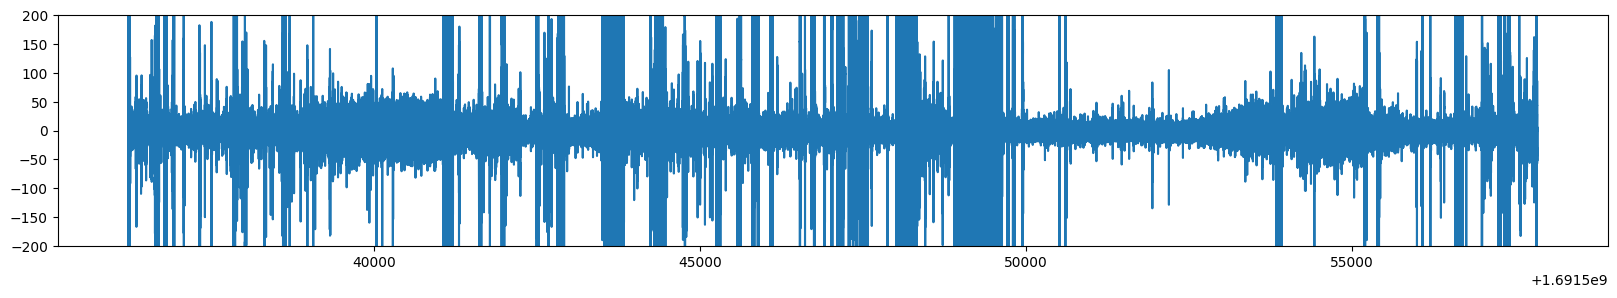

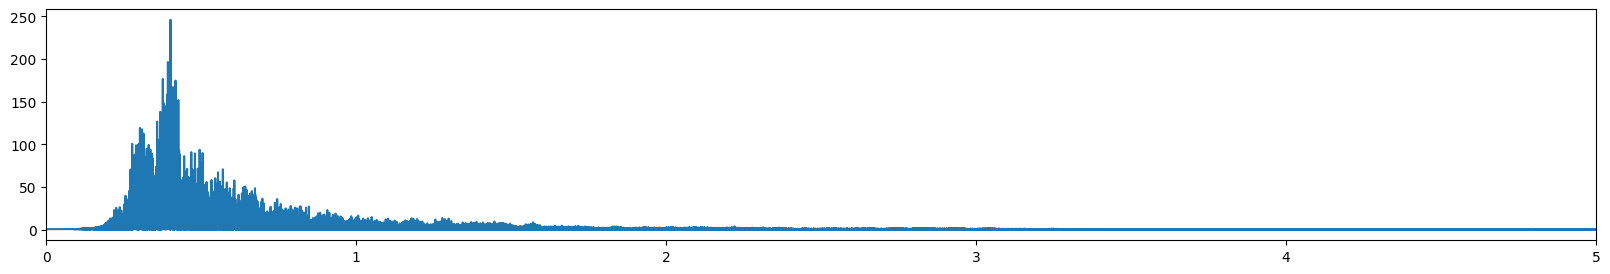

In [28]:
IDUN_SAMPLE_RATE = 250
idun_data = idun_raw_data[:,1]
idun_time_stamps = idun_raw_data[:,0]

# bandpass filter
idun_filtered_data = do_bandpass(idun_data, [0.3, 40], IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)

id_freqs, id_fft = prepare_fft(idun_filtered_data, 0,30 ,IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(id_freqs, id_fft)
plt.xlim(0,5)